In [1]:
%matplotlib inline

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from __future__ import print_function, division
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.sql import SparkSession

from numpy import array
from math import sqrt

spark = SparkSession.builder.master("local[2]") \
   .appName("test") \
   .enableHiveSupport() \
   .getOrCreate()

sc = spark.sparkContext

In [5]:
!head ../data/kmeans_data.txt

5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5.0,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa
4.9,3.1,1.5,0.1,Iris-setosa


In [6]:
# Load and parse the data
data = sc.textFile("../data/kmeans_data.txt")
parsedData = data.map(lambda line: line.split(',')[:4]).map(lambda line: array([float(x) for x in line]))



In [7]:
parsedData.take(5)

[array([5.1, 3.5, 1.4, 0.2]),
 array([4.9, 3. , 1.4, 0.2]),
 array([4.7, 3.2, 1.3, 0.2]),
 array([4.6, 3.1, 1.5, 0.2]),
 array([5. , 3.6, 1.4, 0.2])]

In [8]:
# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 5, maxIterations=20, initializationMode="random")



In [9]:
clusters.centers

[array([5.53214286, 2.63571429, 3.96071429, 1.22857143]),
 array([6.19655172, 2.88275862, 5.18275862, 1.93448276]),
 array([5.006, 3.418, 1.464, 0.244]),
 array([7.12272727, 3.11363636, 6.03181818, 2.13181818]),
 array([6.42380952, 2.91904762, 4.6047619 , 1.43809524])]

In [10]:
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))


Within Set Sum of Squared Error = 78.6798974525


In [11]:
WSSSE_list = []

for k in range(2, 20):
    clusters = KMeans.train(parsedData, k, maxIterations=10, initializationMode="random") #initial ponit randomly set
    WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    WSSSE_list.append((WSSSE))
    

In [12]:
WSSSE_list

[128.40419523672944,
 123.84974501791002,
 90.71614007634946,
 77.28877454693666,
 74.84117711566434,
 68.8373532030829,
 74.26622345400423,
 60.14431957594368,
 58.46003278105789,
 58.145556940467756,
 56.422190142360776,
 54.13509928352681,
 53.26321601872968,
 52.13210751019286,
 52.16221182986467,
 49.17062611425296,
 48.92360068628257,
 48.39950583341344]

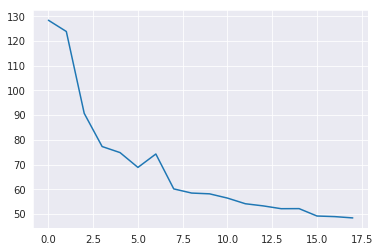

In [15]:
sns.set_style("darkgrid")
plt.plot(WSSSE_list)
plt.show()

In [16]:
spark.stop()